In [84]:
%matplotlib inline

In [85]:
#export
from exp.nb_01 import *

def getMnistData():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(lambda data: tensor(data).cuda(), (x_train,y_train,x_valid,y_valid))

def normalizeVector(vectorToNormalize, vectorMean, vectorStandardDeviation): 
    return (vectorToNormalize-vectorMean)/vectorStandardDeviation

def assertNearZero(someScalar,tol=1e-3): assert someScalar.abs()<tol, f"Near zero: {someScalar}"

In [86]:
def linearCombination(vector, matrix, biasVector): return vector @ matrix + biasVector
def reLU(vector): return vector.clamp_min(0.)

**Math Translation**

- **x** is the values that we are given (in this case it is a bunch of vectors that repersent images of numbers)
- **y** is the expected values that we want to predict (eg, is the image a "1" or "5")

In [87]:
xTrainingSet, yTrainingSet, xValidationSet, yValidationSet = getMnistData()

### Data Normalization

Data needs to be [normalized](https://en.wikipedia.org/wiki/Normalization_(statistics)) so that it reduces the impact of outliers on the data set.

One standard normaliziation is [standard score](https://en.wikipedia.org/wiki/Standard_score) which gives the data set a Gaussian Bell curve characteristic.

**This is how we will normalize the image data**


$$normalizedStandardScore ={value-mean  \over standardDeviation }$$

or in nerd words

$$z ={x-\mu \over \sigma}$$



In [88]:
xTrainingSetMean, xTrainingSetStandardDeviation = xTrainingSet.mean(), xTrainingSet.std()

In [89]:
(xTrainingSetMean, xTrainingSetStandardDeviation)

(tensor(0.1304, device='cuda:0'), tensor(0.3073, device='cuda:0'))

**Time to normalize**

In [90]:
xTrainingSetNormalized = normalizeVector(xTrainingSet, xTrainingSetMean, xTrainingSetStandardDeviation).cuda()

In [91]:
xValidationSetNormalized = normalizeVector(xValidationSet, xValidationSet.mean(), xValidationSet.std()).cuda()

Now that our data has been normalized, we would expect the mean of the normalized data to be somewhere around zero, like the bell curve would assume.

![Bell Curve](./images/The_Normal_Distribution.png)

In [92]:
assertNearZero(xTrainingSetNormalized.mean())
assertNearZero(xValidationSetNormalized.mean())


The standard deviation, or $\sigma$ (sigma), of a **normalized distribution** should be 1.

In [93]:
assertNearZero(1 - xTrainingSetNormalized.std())
assertNearZero(1 - xValidationSetNormalized.std())

**Side Note**

Just because the data is normalized, does not change the fact that the images remain intact

In [94]:
# Change default color to plasma
plotter.rcParams['image.cmap'] = 'plasma'

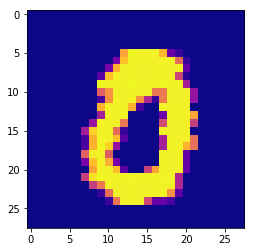

In [95]:
plotter.imshow(xTrainingSet[69].cpu().view(28,28))

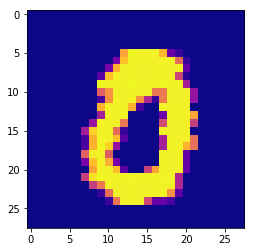

In [96]:
plotter.imshow(xTrainingSetNormalized[69].cpu().view(28,28))

#### Capture Data Set Dimensions

In [97]:
xRows, xColumns = xTrainingSetNormalized.shape
inputChannels = yTrainingSet.max() + 1
(xRows, xColumns, inputChannels)

(50000, 784, tensor(10, device='cuda:0'))

### Convolutional Neural Network Setup

In [98]:
numberOfHiddenNodes = 50

#### Layer Initialization

Setting each layer in our convolutional network is important. Getting the right set of inital weights can lead to really good outputs. The following layer (done below) will have referenced the paper [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852).

Paper Dictonary
---
- $c$ - Number of Input Channels
- $\operatorname {Var} [\vec{v}]$ - Variance of input vector, aka $\sigma ^{2}$ (sigma squared), 
- $\operatorname {E} [\vec{v}]$ - Mean of itput vector, aka $\mu$ (mu)
- $b$ - Bias Vector
- $n$ - Number of Columns

##### Section 2.2 Synopsis
Your weighted matrices should be initilaized such that the mean should be zero and the rest are symetrically dispresed around that mean (eg normalized).

**Simple Initialization**

Dividing the tensor by the number of total inputs of the each image brings the mean way down to zero. The distribution is also expected to have a standard deviation $\sigma$ (sigma) of 1.

In [99]:
weightedLayerOne = (torch.randn(xColumns, numberOfHiddenNodes) / math.sqrt(xColumns)).cuda()
weightedLayerTwo = (torch.randn(numberOfHiddenNodes, 1) / math.sqrt(numberOfHiddenNodes)).cuda()

In [100]:
assertNearZero(weightedLayerOne.mean())
assertNearZero(weightedLayerOne.std() - 1/math.sqrt(xColumns))

> We also initialize $b$ = 0.

In [101]:
biasVectorLayerOne = torch.zeros(numberOfHiddenNodes).cuda()
biasVectorLayerTwo = torch.zeros(1).cuda()

Any linear combination of the initialized layers should have a $\mu$=0 and $\sigma$=1 because $y$ is just a linear combination of $\vec{x}W + \vec{b}$

In [102]:
assertNearZero(xValidationSetNormalized.mean())
assertNearZero(1 - xValidationSetNormalized.std())

In [103]:
xValidationSetNormalized.shape, weightedLayerOne.shape

(torch.Size([10000, 784]), torch.Size([784, 50]))

In [104]:
linearWomboCombo = linearCombination(xValidationSetNormalized, weightedLayerOne, biasVectorLayerOne)

**Kaiming Note:**
These should be close to zero because of our initializaitons, but this appears to not be the case.

_The same goes for `reLU` processed vectors_

In [105]:
linearWomboCombo.mean(), linearWomboCombo.std()

(tensor(0.1179, device='cuda:0'), tensor(1.0075, device='cuda:0'))

In [106]:
reLUWomboCombo = reLU(linearCombination(xValidationSetNormalized, weightedLayerOne, biasVectorLayerOne))

In [107]:
reLUWomboCombo.mean(), reLUWomboCombo.std()

(tensor(0.4602, device='cuda:0'), tensor(0.6286, device='cuda:0'))

**Paper Revelation**

Apparently scaling the intialization matrix down by dividing it by it's standard deviation apparently helps a bunch.

>This leads to a zero-mean Gaussian distribution whose standard deviation (std) is $\sqrt {2/n}$

In [108]:
kaimingInitializedWeightedMatrixOne = (torch.randn(xColumns, numberOfHiddenNodes) * math.sqrt(2/xColumns)).cuda()

In [109]:
assertNearZero(kaimingInitializedWeightedMatrixOne.mean())
assertNearZero(kaimingInitializedWeightedMatrixOne.std() - 1 * math.sqrt(2/xColumns))

**Success!**
Now we get to use the library method!

In [110]:
#export
from torch.nn import init

In [111]:
libraryKiamingWeightedMatrix = torch.zeros(xColumns, numberOfHiddenNodes).cuda()

In [112]:
init.kaiming_normal_(libraryKiamingWeightedMatrix, mode='fan_out')
assertNearZero(libraryKiamingWeightedMatrix.mean())
assertNearZero(libraryKiamingWeightedMatrix.std() - 1 * math.sqrt(2/xColumns))

In [113]:
testMatrix = torch.zeros(xColumns, numberOfHiddenNodes)

In [114]:
%timeit init.kaiming_normal_(testMatrix, mode='fan_out')

408 µs ± 733 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [115]:
%timeit torch.randn(xColumns, numberOfHiddenNodes) * math.sqrt(2/xColumns)

425 µs ± 800 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Getting closer to Ideal

Apparently the Ideal state for our outputs ofter reLU transformation is to have a mean of zero
    $$\mu \approx 0$$
And a standard deviation of one
    $$\sigma \approx 1$$

In [116]:
forwardPass = reLU(linearCombination(xValidationSetNormalized, 
                                     libraryKiamingWeightedMatrix, 
                                     biasVectorLayerOne))

In [117]:
forwardPass.mean(), forwardPass.std()

(tensor(0.6096, device='cuda:0'), tensor(0.8561, device='cuda:0'))

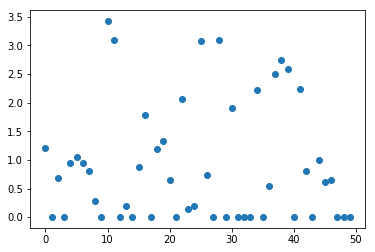

In [118]:
plotter.scatter(x=range(numberOfHiddenNodes), y=forwardPass[0].cpu())

In [119]:
def reLUEnhanced(vector): return vector.clamp_min(0.) - 0.5 # moves all the points above zero down to zero

In [120]:
enhancedForwardPass = reLUEnhanced(linearCombination(xValidationSetNormalized, 
                                                     libraryKiamingWeightedMatrix, 
                                                     biasVectorLayerOne))

**Shifting closer to zero**

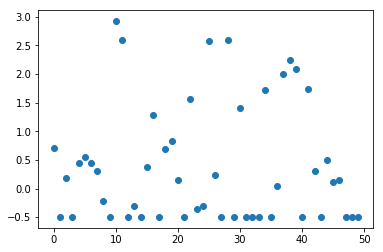

In [121]:
plotter.scatter(x=range(numberOfHiddenNodes), y=enhancedForwardPass[0].cpu())

In [122]:
enhancedForwardPass.mean(), enhancedForwardPass.std()

(tensor(0.1096, device='cuda:0'), tensor(0.8561, device='cuda:0'))

In [123]:
finalLibraryKiamingWeightedMatrix = torch.zeros(numberOfHiddenNodes, 1).cuda()

In [124]:
init.kaiming_normal_(finalLibraryKiamingWeightedMatrix, mode='fan_out')
print('dun')

dun


## Simple Forward Pass CNN Model


Take a look at what the input matrix's shape will be and then observe how the 2 weighted convolution matrices' shapes play into that.

In [125]:
xTrainingSetNormalized.shape, libraryKiamingWeightedMatrix.shape, finalLibraryKiamingWeightedMatrix.shape

(torch.Size([50000, 784]), torch.Size([784, 50]), torch.Size([50, 1]))

In [126]:
def simpleModel(inputMatrix):
    firstActivations = linearCombination(inputMatrix, 
                                         libraryKiamingWeightedMatrix, 
                                         biasVectorLayerOne)
    clampedFirstActivations = reLUEnhanced(firstActivations)
    lastActivations = linearCombination(clampedFirstActivations, 
                                        finalLibraryKiamingWeightedMatrix, 
                                        biasVectorLayerTwo)
    return lastActivations

In [127]:
%time predictions = simpleModel(xTrainingSetNormalized)

CPU times: user 565 µs, sys: 0 ns, total: 565 µs
Wall time: 373 µs


In [128]:
assert predictions.shape == torch.Size([xTrainingSetNormalized.shape[0], 1]), "{} does not equal {}".format(predictions.shape, torch.Size([xTrainingSetNormalized.shape[0], 1]))

### Getting ready to learn!
**Loss function**




In [129]:
#export
def assertSameShape(actualVector, expectedVector):
    assert actualVector.shape == expectedVector.shape, "Input vectors do not have the same shape! {} and {}".format(actualVector.shape, expectedVector.shape)
def meanSquaredError(actualVector, expectedVector):
    assertSameShape(actualVector, expectedVector)
    return (actualVector - expectedVector).pow(2).mean()
    

In [130]:
%time loss = meanSquaredError(predictions.squeeze(-1), yTrainingSet.float())

CPU times: user 943 µs, sys: 0 ns, total: 943 µs
Wall time: 748 µs


In [131]:
loss

tensor(17.5211, device='cuda:0')

The goal now is to minimize error, and we can do this by the process of backwards propagation.

**Taking the deriviative (finding the gradient of the slope) of the loss function**

*quick note*: `unsqueeze(-1)` will add a dimension to a vector eg `size([4])` -> `size([4, 1])` after unsqueezing

In [132]:
def meanSquaredErrorGradient(actualVector, expectedVector):
    squeezedActualVector = actualVector.squeeze(-1)
    assertSameShape(squeezedActualVector, expectedVector)
    lossVector = (squeezedActualVector - expectedVector)
    actualVector.storedGradients = 2. * lossVector.unsqueeze(-1) / squeezedActualVector.shape[0]

In [133]:
def reLUErrorGradient(previousActivations, nextActivations):
    previousActivations.storedGradients = (previousActivations > 0).float() * nextActivations.storedGradients

In [143]:
def linearCombinationErrorGradient(inputMatrix, activationMatrix, weightedMatrix, biasVector):
    inputMatrix.storedGradients = activationMatrix.storedGradients @ weightedMatrix.t() # t for transpose
    weightedMatrixGradients = (inputMatrix.unsqueeze(-1) * activationMatrix.storedGradients.unsqueeze(-1)).sum(0)
    weightedMatrix.storedGradients = weightedMatrixGradients
    biasVector.storedGradients = activationMatrix.storedGradients.sum(0)

In [147]:
def churnThenLearn(testInputs, validationOutputs):
    #Churn
    firstLayerActivations = linearCombination(testInputs, 
                                              libraryKiamingWeightedMatrix, 
                                              biasVectorLayerOne)
    clampedFirstActivations = reLUEnhanced(firstLayerActivations)
    finalLayerActivations = linearCombination(clampedFirstActivations, 
                                              finalLibraryKiamingWeightedMatrix, 
                                              biasVectorLayerTwo)
    
    loss = meanSquaredError(finalLayerActivations.squeeze(-1), validationOutputs)
    print("Loss = {}".format(loss))
    
    #Learn
    meanSquaredErrorGradient(finalLayerActivations, validationOutputs)
    linearCombinationErrorGradient(clampedFirstActivations, 
                                   finalLayerActivations, 
                                   finalLibraryKiamingWeightedMatrix,
                                   biasVectorLayerTwo)
    reLUErrorGradient(firstLayerActivations, finalLayerActivations)
    linearCombinationErrorGradient(firstLayerActivations, 
                                   clampedFirstActivations, 
                                   libraryKiamingWeightedMatrix, 
                                   biasVectorLayerOne)
    print(biasVectorLayerOne.storedGradients)
    return firstLayerActivations, finalLayerActivations, biasVectorLayerOne, biasVectorLayerTwo, testInputs

In [148]:
libraryKiamingWeightedMatrix.storedGradients,biasVectorLayerOne.storedGradients,finalLibraryKiamingWeightedMatrix.storedGradients,biasVectorLayerTwo.storedGradients = [None]*4 

In [149]:
%time firstLayerActivations, finalLayerActivations, biasVectorLayerOne, biasVectorLayerTwo, testInputs = churnThenLearn(xTrainingSetNormalized, yTrainingSet.float())

Loss = 17.521068572998047
tensor([-6.1557], device='cuda:0')
tensor([-0.1415,  0.1025, -0.8417,  0.5738,  0.9135, -0.1257, -1.2910, -1.6309,
        -0.7278,  0.8069, -2.1002, -0.6503,  0.6072, -1.3273, -0.9282,  0.4091,
        -0.8386, -0.5089,  2.4369, -0.1414,  0.8685, -0.4369,  3.6112,  0.7773,
        -0.2282,  1.3746, -0.4636,  1.7433,  1.1299,  1.0155,  1.4915,  0.3330,
        -1.6995, -1.5628, -0.5216, -0.7752,  1.5955, -1.7569, -0.3947, -1.0766,
        -0.4512,  2.7352, -1.9251, -1.1356, -1.1130, -0.3359,  0.3295,  3.0265,
        -2.4082, -0.4010], device='cuda:0')
tensor([-0.1415,  0.1025, -0.8417,  0.5738,  0.9135, -0.1257, -1.2910, -1.6309,
        -0.7278,  0.8069, -2.1002, -0.6503,  0.6072, -1.3273, -0.9282,  0.4091,
        -0.8386, -0.5089,  2.4369, -0.1414,  0.8685, -0.4369,  3.6112,  0.7773,
        -0.2282,  1.3746, -0.4636,  1.7433,  1.1299,  1.0155,  1.4915,  0.3330,
        -1.6995, -1.5628, -0.5216, -0.7752,  1.5955, -1.7569, -0.3947, -1.0766,
        -0.4512

In [151]:
w1g = firstLayerActivations.storedGradients.clone()
w2g = finalLayerActivations.storedGradients.clone()
b1g = biasVectorLayerOne.storedGradients.clone()
b2g = biasVectorLayerTwo.storedGradients.clone()
# ig  = testInputs.storedGradients.clone()
xt2 = testInputs.clone().requires_grad_(True)
w12 = firstLayerActivations.clone().requires_grad_(True)
w22 = finalLayerActivations.clone().requires_grad_(True)
b12 = biasVectorLayerOne.clone().requires_grad_(True)
b22 = biasVectorLayerTwo.clone().requires_grad_(True)
def forward(inp, targ):
    # forward pass:
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    # we don't actually need the loss in backward!
    return mse(out, targ)
loss = forward(xt2, yTrainingSet)
loss.backward()

RuntimeError: size mismatch, m1: [50000 x 784], m2: [50000 x 50] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266